In [2]:
import av
import numpy as np
from PIL import Image
import os
import time

class VideoEncoder:
    def __init__(self, block_size=16, search_radius=8):
        self.block_size = block_size
        self.search_radius = search_radius
    
    def extract_frames(self, video_path, output_dir):
        """Извлекает кадры из видео и сохраняет их как JPEG."""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        container = av.open(video_path)
        stream = container.streams.video[0]
        
        frames = []
        for frame in container.decode(stream):
            # Преобразование в массив numpy в формате grayscale
            img_array = frame.to_ndarray(format='gray')
            frames.append(img_array)
            
        return frames
    
    def sat_metric(self, block1, block2):
        """Вычисляет метрику SAT между двумя блоками."""
        return np.sum(np.abs(block1 - block2))
    
    def logarithmic_search(self, curr_block, ref_frame, x, y):
        """Реализует логарифмический поиск для оценки движения."""
        step_size = self.search_radius
        min_x, min_y = x, y
        min_cost = float('inf')
        
        while step_size >= 1:
            for dx in [-step_size, 0, step_size]:
                for dy in [-step_size, 0, step_size]:
                    new_x = min_x + dx
                    new_y = min_y + dy
                    
                    # Проверка границ
                    if (new_x < 0 or new_x + self.block_size > ref_frame.shape[1] or
                        new_y < 0 or new_y + self.block_size > ref_frame.shape[0]):
                        continue
                    
                    ref_block = ref_frame[new_y:new_y+self.block_size, 
                                        new_x:new_x+self.block_size]
                    cost = self.sat_metric(curr_block, ref_block)
                    
                    if cost < min_cost:
                        min_cost = cost
                        min_x, min_y = new_x, new_y
            
            step_size //= 2
            
        return min_x - x, min_y - y
    
    def motion_estimation(self, current_frame, reference_frame):
        """Оценка движения для всего кадра."""
        height, width = current_frame.shape
        motion_vectors = np.zeros((height // self.block_size, 
                                 width // self.block_size, 2))
        
        for i in range(0, height - self.block_size + 1, self.block_size):
            for j in range(0, width - self.block_size + 1, self.block_size):
                curr_block = current_frame[i:i+self.block_size, 
                                        j:j+self.block_size]
                
                dx, dy = self.logarithmic_search(curr_block, reference_frame, j, i)
                
                motion_vectors[i//self.block_size, 
                            j//self.block_size] = [dx, dy]
                
        return motion_vectors
    
    def motion_compensation(self, reference_frame, motion_vectors):
        """Компенсация движения для восстановления кадра."""
        height, width = reference_frame.shape
        compensated = np.zeros_like(reference_frame)
        
        for i in range(motion_vectors.shape[0]):
            for j in range(motion_vectors.shape[1]):
                dx, dy = motion_vectors[i, j]
                
                ref_y = i * self.block_size
                ref_x = j * self.block_size
                
                src_y = int(ref_y + dy)
                src_x = int(ref_x + dx)
                
                # Проверка границ
                if (src_x >= 0 and src_x + self.block_size <= width and
                    src_y >= 0 and src_y + self.block_size <= height):
                    compensated[ref_y:ref_y+self.block_size, 
                              ref_x:ref_x+self.block_size] = \
                        reference_frame[src_y:src_y+self.block_size, 
                                     src_x:src_x+self.block_size]
                
        return compensated
    
    def encode_video(self, input_path, output_dir):
        """Основной метод кодирования видео."""
        frames = self.extract_frames(input_path, output_dir)
        
        for i in range(1, len(frames)):
            # Оценка движения
            motion_vectors = self.motion_estimation(frames[i], frames[i-1])
            
            # Компенсация движения
            compensated_frame = self.motion_compensation(frames[i-1], motion_vectors)
            
            # Разница между текущим и компенсированным кадром
            residual = frames[i] - compensated_frame
            
            # Сохранение кадра
            self.save_frame(frames[i], os.path.join(output_dir, f'frame_{i}.jpg'))
            
            # Вывод прогресса
            print(f"Обработан кадр {i} из {len(frames)-1}")
            
        return True
    
    def save_frame(self, frame, filepath):
        """Сохраняет кадр как JPEG файл."""
        # Нормализация значений для сохранения в формате JPEG
        normalized = np.clip(frame, 0, 255).astype(np.uint8)
        image = Image.fromarray(normalized)
        image.save(filepath)

def main():
    # Пути к файлам
    input_video = "lr1_1.avi"
    output_dir = "encoded_frames"
    
    # Создание выходной директории, если её нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Инициализация кодера с параметрами из задания
    encoder = VideoEncoder(block_size=16, search_radius=8)
    
    print("Начало кодирования видео...")
    start_time = time.time()
    
    try:
        # Запуск процесса кодирования
        encoder.encode_video(input_video, output_dir)
        
        # Вывод статистики
        end_time = time.time()
        processing_time = end_time - start_time
        
        print(f"Кодирование завершено успешно!")
        print(f"Время обработки: {processing_time:.2f} секунд")
        print(f"Закодированные кадры сохранены в директории: {output_dir}")
        
    except Exception as e:
        print(f"Ошибка при кодировании: {str(e)}")

if __name__ == "__main__":
    main()

Начало кодирования видео...
Обработан кадр 1 из 67
Обработан кадр 2 из 67
Обработан кадр 3 из 67
Обработан кадр 4 из 67
Обработан кадр 5 из 67
Обработан кадр 6 из 67
Обработан кадр 7 из 67
Обработан кадр 8 из 67
Обработан кадр 9 из 67
Обработан кадр 10 из 67
Обработан кадр 11 из 67
Обработан кадр 12 из 67
Обработан кадр 13 из 67
Обработан кадр 14 из 67
Обработан кадр 15 из 67
Обработан кадр 16 из 67
Обработан кадр 17 из 67
Обработан кадр 18 из 67
Обработан кадр 19 из 67
Обработан кадр 20 из 67
Обработан кадр 21 из 67
Обработан кадр 22 из 67
Обработан кадр 23 из 67
Обработан кадр 24 из 67
Обработан кадр 25 из 67
Обработан кадр 26 из 67
Обработан кадр 27 из 67
Обработан кадр 28 из 67
Обработан кадр 29 из 67
Обработан кадр 30 из 67
Обработан кадр 31 из 67
Обработан кадр 32 из 67
Обработан кадр 33 из 67
Обработан кадр 34 из 67
Обработан кадр 35 из 67
Обработан кадр 36 из 67
Обработан кадр 37 из 67
Обработан кадр 38 из 67
Обработан кадр 39 из 67
Обработан кадр 40 из 67
Обработан кадр 41 из 

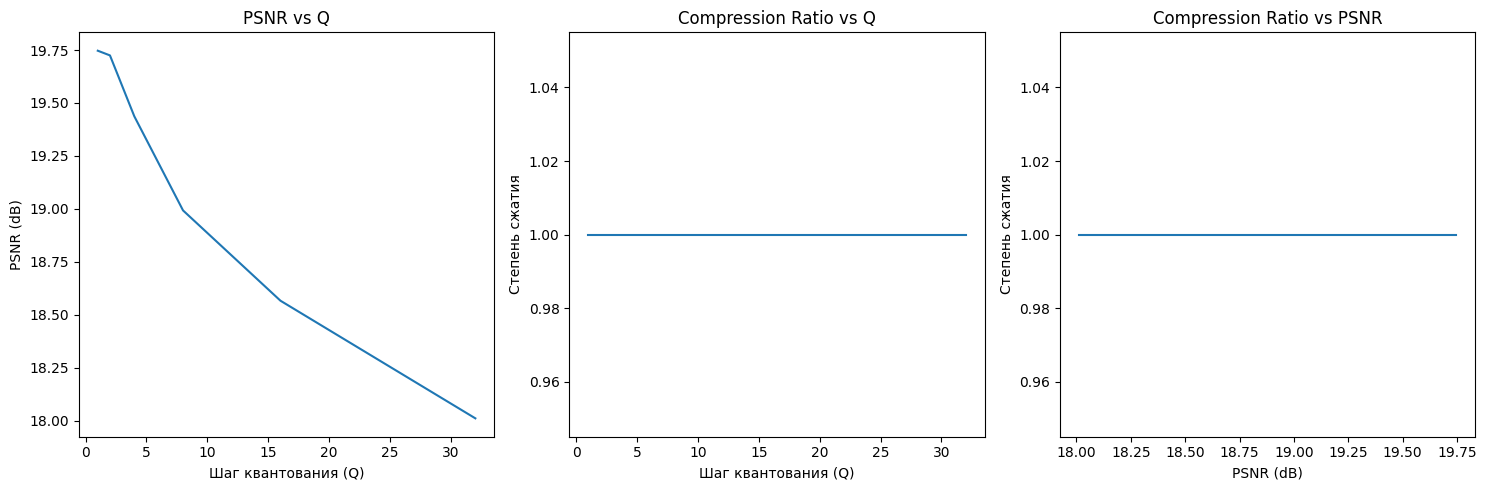

In [4]:
import av
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy.fftpack import dct, idct
import math

def dct2d(block: np.ndarray) -> np.ndarray:
    """
    Двумерное ДКП
    """
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2d(block: np.ndarray) -> np.ndarray:
    """
    Обратное двумерное ДКП
    """
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def quantize(block: np.ndarray, q_step: int) -> np.ndarray:
    """
    Квантование ДКП коэффициентов
    """
    return np.round(block / q_step) * q_step

def logarithmic_search(curr_block: np.ndarray, 
                    reference_frame: np.ndarray, 
                    x: int, 
                    y: int, 
                    search_radius: int = 8) -> Tuple[int, int]:
    """
    Реализация алгоритма логарифмического поиска для оценки движения
    """
    block_size = curr_block.shape[0]
    best_x, best_y = x, y
    best_sad = float('inf')
    step = search_radius // 2

    while step >= 1:
        for dx in [-step, 0, step]:
            for dy in [-step, 0, step]:
                new_x = x + dx
                new_y = y + dy
                
                if (new_x < 0 or new_x + block_size > reference_frame.shape[0] or
                    new_y < 0 or new_y + block_size > reference_frame.shape[1]):
                    continue
                
                reference_block = reference_frame[new_x:new_x+block_size, 
                                            new_y:new_y+block_size]
                
                sad = np.sum(np.abs(curr_block - reference_block))
                
                if sad < best_sad:
                    best_sad = sad
                    best_x = new_x
                    best_y = new_y
        
        step //= 2
    
    return best_x - x, best_y - y

def process_block(block: np.ndarray, q_step: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Обработка блока: ДКП -> Квантование -> Обратное ДКП
    """
    # Прямое ДКП
    dct_block = dct2d(block.astype(np.float64))
    
    # Квантование
    quantized_block = quantize(dct_block, q_step)
    
    # Обратное ДКП
    reconstructed_block = idct2d(quantized_block)
    
    return quantized_block, reconstructed_block

def compute_motion_compensated_frame(current: np.ndarray, 
                                reference: np.ndarray,
                                block_size: int = 16,
                                search_radius: int = 8,
                                q_step: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Вычисление разностного кадра с компенсацией движения и его обработка
    """
    height, width = current.shape
    motion_vectors = np.zeros((height // block_size, width // block_size, 2), dtype=np.int8)
    diff_frame = np.zeros_like(current, dtype=np.int16)
    predicted_frame = np.zeros_like(current, dtype=np.uint8)
    reconstructed_frame = np.zeros_like(current, dtype=np.uint8)
    
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            curr_block = current[i:i+block_size, j:j+block_size]
            
            # Оценка движения
            dx, dy = logarithmic_search(curr_block, reference, i, j, search_radius)
            motion_vectors[i // block_size, j // block_size] = [dx, dy]
            
            # Компенсация движения
            reference_block = reference[i+dx:i+dx+block_size, j+dy:j+dy+block_size]
            predicted_frame[i:i+block_size, j:j+block_size] = reference_block
            
            # Вычисление разностного блока
            diff_block = curr_block.astype(np.int16) - reference_block.astype(np.int16)
            
            # ДКП, квантование и обратное ДКП
            _, reconstructed_diff = process_block(diff_block, q_step)
            
            # Сохранение разностного блока для визуализации
            diff_frame[i:i+block_size, j:j+block_size] = diff_block
            
            # Восстановление блока
            reconstructed_block = np.clip(reference_block.astype(np.int16) + 
                                    reconstructed_diff, 0, 255).astype(np.uint8)
            reconstructed_frame[i:i+block_size, j:j+block_size] = reconstructed_block
            
    return diff_frame, reconstructed_frame, predicted_frame

def process_video(input_path: str, output_diff_path: str, output_recon_path: str, 
                q_step: int = 1) -> Tuple[float, float]:
    """
    Обработка видео с сохранением разностных и восстановленных кадров
    """
    container = av.open(input_path)
    diff_container = av.open(output_diff_path, mode='w')
    recon_container = av.open(output_recon_path, mode='w')
    
    # Настройка выходных потоков
    diff_stream = diff_container.add_stream('mpeg4', 
                                        rate=container.streams.video[0].codec_context.rate)
    recon_stream = recon_container.add_stream('mpeg4',
                                            rate=container.streams.video[0].codec_context.rate)
    
    for stream in [diff_stream, recon_stream]:
        stream.width = container.streams.video[0].width
        stream.height = container.streams.video[0].height
        stream.pix_fmt = 'yuv420p'
    
    frames = []
    previous_frame = None
    total_original_size = 0
    total_compressed_size = 0
    
    for frame in container.decode(video=0):
        # Извлечение компоненты Y
        img = frame.to_ndarray(format='yuv420p')
        y_component = img[:diff_stream.height, :diff_stream.width].astype(np.uint8)
        
        if previous_frame is None:
            # Первый кадр сохраняем без изменений
            diff_frame = np.zeros_like(y_component)
            reconstructed_frame = y_component.copy()
        else:
            # Для остальных кадров применяем компенсацию движения и ДКП
            diff_frame, reconstructed_frame, _ = compute_motion_compensated_frame(
                y_component, previous_frame, q_step=q_step)
        
        # Клипирование разностного кадра для визуализации
        diff_frame_vis = np.clip(diff_frame + 128, 0, 255).astype(np.uint8)
        
        # Сохранение разностного кадра
        diff_out_frame = av.VideoFrame.from_ndarray(diff_frame_vis, format='gray')
        packet = diff_stream.encode(diff_out_frame)
        diff_container.mux(packet)
        
        # Сохранение восстановленного кадра
        recon_out_frame = av.VideoFrame.from_ndarray(reconstructed_frame, format='gray')
        packet = recon_stream.encode(recon_out_frame)
        recon_container.mux(packet)
        
        frames.append(reconstructed_frame)
        previous_frame = reconstructed_frame  # Используем восстановленный кадр как опорный
        
        total_original_size += y_component.size
        total_compressed_size += reconstructed_frame.size
    
    # Очистка буферов энкодеров
    for stream, container in [(diff_stream, diff_container), 
                            (recon_stream, recon_container)]:
        for packet in stream.encode():
            container.mux(packet)
        container.close()
    
    container.close()
    
    # Вычисление метрик
    avg_psnr = np.mean([calculate_psnr(frames[i], frames[i+1]) 
                        for i in range(len(frames)-1)])
    compression_ratio = total_original_size / total_compressed_size
    
    return avg_psnr, compression_ratio

def calculate_psnr(original: np.ndarray, compressed: np.ndarray) -> float:
    """
    Вычисление PSNR между оригинальным и сжатым изображением
    """
    mse = np.mean((original.astype(np.float64) - compressed.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def plot_metrics(q_steps: List[int], 
                psnr_values: List[float], 
                compression_ratios: List[float]):
    """
    Построение графиков метрик
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.plot(q_steps, psnr_values)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Q')
    
    plt.subplot(132)
    plt.plot(q_steps, compression_ratios)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs Q')
    
    plt.subplot(133)
    plt.plot(psnr_values, compression_ratios)
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs PSNR')
    
    plt.tight_layout()
    plt.show()

def main():
    input_path = 'lr1_1.avi'
    q_steps = [1, 2, 4, 8, 16, 32]
    psnr_values = []
    compression_ratios = []
    
    for q in q_steps:
        psnr, ratio = process_video(
            input_path, 
            f'diff_q{q}.avi',  # Файл с разностными кадрами
            f'recon_q{q}.avi',  # Файл с восстановленными кадрами
            q
        )
        psnr_values.append(psnr)
        compression_ratios.append(ratio)
    
    plot_metrics(q_steps, psnr_values, compression_ratios)

if __name__ == '__main__':
    main()